In [6]:
import sys
print(sys.version)
import sklearn
print(sklearn.__version__)

# Common imports
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
1.3.2


In [7]:
# always do in ML to ensure reproducibility
np.random.seed(42)

In [9]:
# load data

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
X, y = mnist["data"], mnist["target"]
print("dataset shape", X.shape)
print("labels shape", y.shape)

dataset shape (70000, 784)
labels shape (70000,)


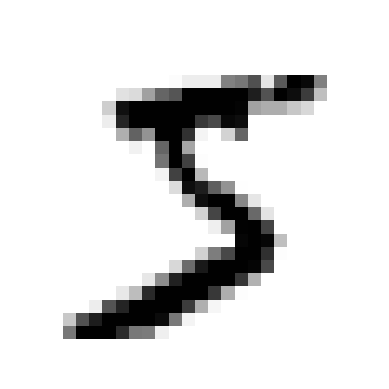

label: 5


In [15]:
# %matplotlib inline # used to plot the figures within the notebook itself
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print("label:", y[0])

In [18]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

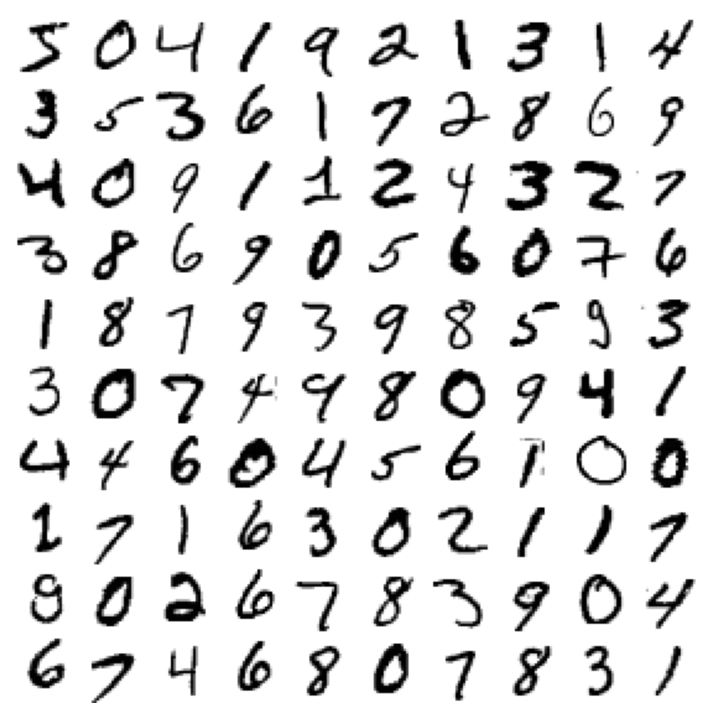

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [20]:
# splitting data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


# Training a Binary Classifier

In [27]:
y_train

array(['5', '0', '4', ..., '5', '6', '8'], dtype=object)

In [31]:
# converting multiple class labels into binary (0 or 1)
y_train_3 = np.where(y_train == '3', 1, 0)
y_test_3 = np.where(y_train == '3', 1, 0)

In [32]:
y_train_3[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [33]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [34]:
sgd_clf.predict([some_digit])  # on "5"

array([0])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [37]:
# 1. Using standard K-fold

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=5, scoring="accuracy")

array([0.92858333, 0.94975   , 0.96316667, 0.96108333, 0.96691667])

In [38]:
# 2. Using Stratified K-fold

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_3[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9430833333333334
0.9653333333333334
0.9500833333333333
0.9649166666666666
0.9646666666666667


## Confusion Matrix

In [39]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3, y_train_pred)

array([[53477,   392],
       [ 2113,  4018]])

In [41]:
y_train_perfect_predictions = y_train_3  # pretend we reached perfection
confusion_matrix(y_train_3, y_train_perfect_predictions)

array([[53869,     0],
       [    0,  6131]])

## Precision and Recall and F1 score

### P = TP/(TP+FP)
### R = TP/(TP+FN)
### F1 = harmonic sum of P and R

In [44]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_3, y_train_pred))
print(recall_score(y_train_3, y_train_pred))

0.9111111111111111
0.655358016636764


In [45]:
from sklearn.metrics import f1_score

f1_score(y_train_3, y_train_pred)

0.7623565126648326

## Precision/Recall Trade-off

In [46]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-3664.79262749])

In [47]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [48]:
y_some_digit_pred

array([False])

In [49]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
                             method="decision_function")

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

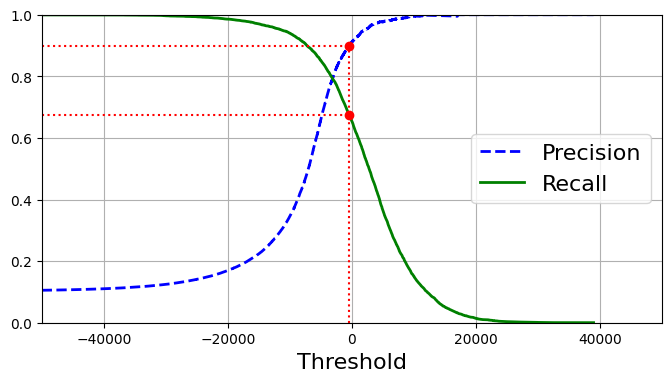

In [53]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
# save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [54]:
(y_train_pred == (y_scores > 0)).all()

True

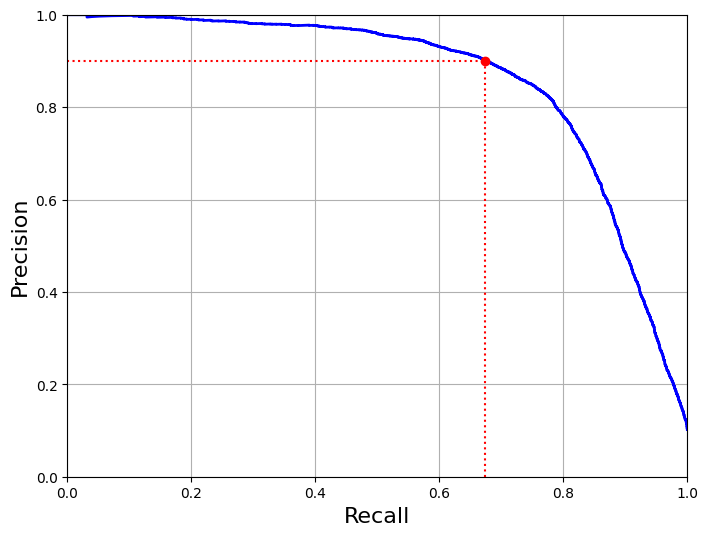

In [55]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
plt.show()

In [56]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

-411.44326592496236

In [57]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [60]:
precision_score(y_train_3, y_train_pred_90)

0.9000870700914236

In [61]:
recall_score(y_train_3, y_train_pred_90)

0.6744413635622247

## The ROC Curve

In [62]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

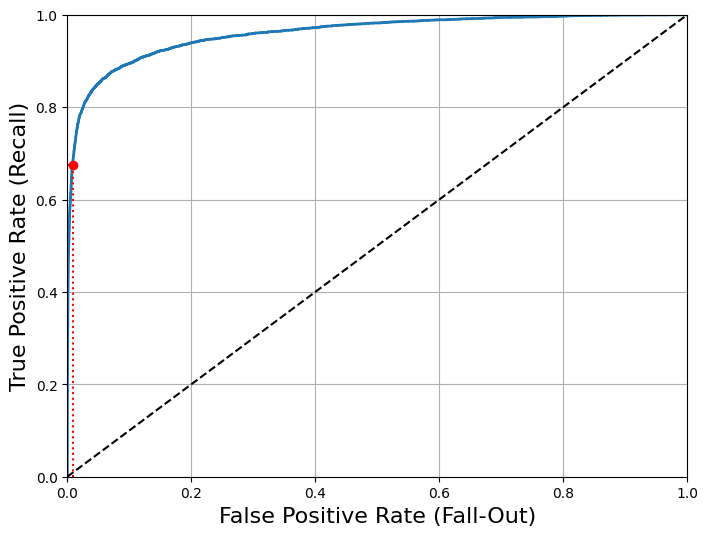

In [63]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.show()

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_3, y_scores)

0.9599243001892759

### Using a different classifier: RandomForestClassifier

In [65]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3,
                                    method="predict_proba")

In [66]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)

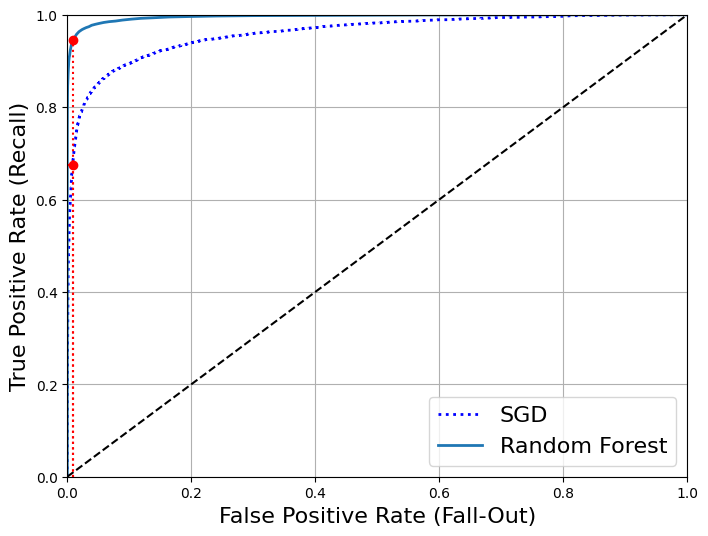

In [67]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
# save_fig("roc_curve_comparison_plot")
plt.show()

In [68]:
roc_auc_score(y_train_3, y_scores_forest)

0.995864544068936

In [69]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
precision_score(y_train_3, y_train_pred_forest)

0.9947481034818129

In [70]:
recall_score(y_train_3, y_train_pred_forest)

0.8341216767248409

## 2. Data Augmentation

In [71]:
from scipy.ndimage.interpolation import shift

<ipython-input-71-c50379b1544a>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [72]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

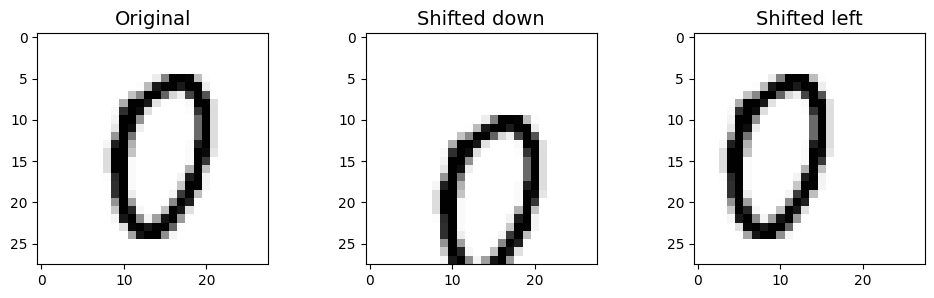

In [73]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [74]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [75]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

### **if we try augmenting dataset, we can achieve better performance for classification!**